# Human stress prediction
The goal of this analysis is to be able to predict whether someone is stressed based on the contents of a reddit post.

The dataset contains a bunch of reddit posts from different subreddits and a way to classify them as `Stress` or `No stress`.

## Importing used libraries


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_recall_fscore_support


## Basic reusable function to quickly test models

To reduce redundancy and be able to more easily compare different models, I made a basic function that produces a **confusion_matrix** and **classification_report** and takes the data and initialized model as parameter inputs. The function really works the same as how you would normally test a model but with the hardcoded values replaced with parameters.

In [11]:
def test_model(Model, Xtrain, Ytrain, Xtest, Ytest):
    Model.fit(Xtrain,Ytrain) #Fit the model
    Model.score(Xtest,Ytest) #Determine the score of the model
    
    Model_Prediction = Model.predict(Xtest)
    accuracy = Model.score(Xtest, Ytest)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(Ytest, Model_Prediction, labels=Model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Model.classes_)
    disp.plot()
    plt.show()

    # Print classification report to check the classification performance
    print(classification_report(Ytest, Model_Prediction, target_names=Model.classes_))

## Naive Bayes model
the first method to approach this binary classification problem is with the Naive Bayes model.

The data preparation and testing of this model is very similar to the KNN model. First the data is loaded and the categories are assigned.

Lastly some overviews and basic data exploration is done to get an idea of what data is in the dataset. The following facts are observed:

- The categories are represented fairly balanced in the datasets
- the column `text` is probably most useful and most interesting for this analysis
- None of the columns contain null values and very little data preperation is needed
- The dataset contains the columns: `label` and `confidence`. `label` can be used to train the model what text is `Stress` or `No stress`. `confidence` can probably be used to tell the model how much weight should be given the learned characteristics of the text for that specific label. I will not be using this column as I am not entirely certain how to properly implement this.

I decied to convert the binary classification of `label` to the category type with the `label_in_value` column for readability purposes. This is not necessary as the model can be directly trained on the binary label.

In [12]:
URL2 = "https://raw.githubusercontent.com/GitJvG/Dataset/refs/heads/main/Stress.csv"

df = pd.read_csv(URL2)
print(df.info())
print(df.head(5))

df['label_in_value']=df['label'].map({0:'No Stress',1:"Stress"})
catType = pd.CategoricalDtype(categories=["Stress", "No Stress"], ordered=False)
df['type'] = df['label_in_value'].astype(catType)

print(df['type'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB
None
          subreddit post_id sentence_range  \
0              ptsd  8601tu       (15, 20)   
1        assistance  8lbrx9         (0, 5)   
2              ptsd  9ch1zh       (15, 20)   
3     relationships  7rorpp        [5, 10]   
4  survivorsofabuse  9p2gbc         [0, 5]   

                                                text  label  confidence  \
0  He said he had not felt that way before, sugge.

## Preparing the `text` column for Naive Bayes

First the top 1000 features from the text column are vectorized. This creates a matrix with numerical representations of the words. Changing the max_features value doesn't majorly impact the model's performance unless you decrease or increase it by a lot. This, however, isn't an aspect with a lot of performance improvement potential beyond what is currently achieved.

A dataframe with vectorized words is created. It uses get_feature_names_out to display the actual words instead of the vectorized numbers. The dataframe however still contains the vectorized values. The displayed words are simply labels to improve readability.

A simple train_test_split is performed to quickly split the dataset after which the custom model testing function is used to generate a confusion matrix and classification report.


    10  100   12   15   16   17   18   20   24   30  ...     years  yelling  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000      0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000      0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000      0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000      0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.093983      0.0   

   yes  yesterday  yet       you  young  younger      your  yourself  
0  0.0   0.000000  0.0  0.078740    0.0      0.0  0.000000       0.0  
1  0.0   0.000000  0.0  0.190737    0.0      0.0  0.000000       0.0  
2  0.0   0.113784  0.0  0.099771    0.0      0.0  0.071922       0.0  
3  0.0   0.000000  0.0  0.032035    0.0      0.0  0.000000       0.0  
4  0.0   0.000000  0.0  0.000000    0.0      0.0  0.000000       0.0  

[5 rows x 1000 columns]
Test Accuracy: 73.52%


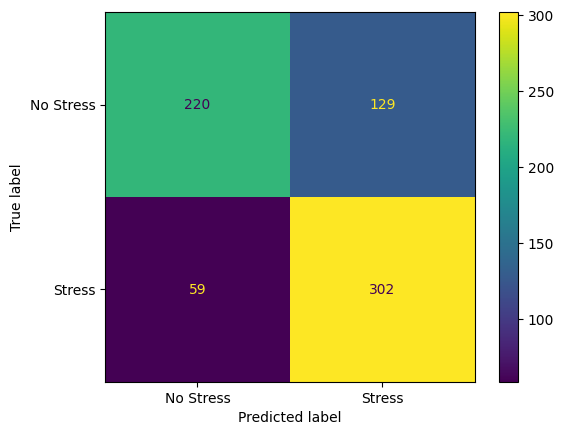

              precision    recall  f1-score   support

   No Stress       0.79      0.63      0.70       349
      Stress       0.70      0.84      0.76       361

    accuracy                           0.74       710
   macro avg       0.74      0.73      0.73       710
weighted avg       0.74      0.74      0.73       710



In [13]:
# Vectorizing the text to be able to calculate similarity with the model.
vectorizer = TfidfVectorizer(max_features=1000)
vectors = vectorizer.fit_transform(df.text)

"""Creating dummy columns for every word in the text column that contain 1 or 0 depending on whether they exist in the text of that row"""
wordsDF = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())
print(wordsDF.head())

"""Splitting the data into test and train datasets, This could be improved by using Kfold so all data is used for training"""
xTrain, xTest, yTrain, yTest = train_test_split(wordsDF, df.type)

"""Initializing the bayes model"""
bayes = MultinomialNB()
# Fitting the model
bayes.fit(xTrain, yTrain)

test_model(bayes, xTrain, yTrain, xTest, yTest)


## Model improvement attempts

To improve the model's performance an obvious measure to attempt is to switch from the train_test_split method to K-fold Cross-Validation. By using K-fold Cross-Validation you ensure the data uses everything from the dataset as training and evaluation data without compromising its integrity.

The following code defines a function that performs K-fold Cross-validation and calculates the averages of all metrics separately over the folds to generate a custom 'average' classification report.

In [14]:
def test_model_kfold(Model, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize accumulators for precision, recall, f1-score, and support
    precision_acc = []
    recall_acc = []
    f1_acc = []
    support_acc = []
    accuracy_acc = []

    # KFold cross-validation loop
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the model
        Model.fit(X_train, y_train)

        # Predict on test set
        y_pred = Model.predict(X_test)

        # Collect precision, recall, f1-score, support for each loop again
        precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None, labels=Model.classes_)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Append the new scores to the '_acc' variable, this way the results of previous folds aren't overwritten but appended to.
        precision_acc.append(precision)
        recall_acc.append(recall)
        f1_acc.append(f1)
        support_acc.append(support)
        accuracy_acc.append(accuracy)

    # Convert accumulators to numpy arrays for easier summation
    precision_acc = np.array(precision_acc)
    recall_acc = np.array(recall_acc)
    f1_acc = np.array(f1_acc)
    support_acc = np.array(support_acc)
    accuracy_acc = np.array(accuracy_acc)

    # Compute averages across all folds
    avg_precision = np.mean(precision_acc, axis=0)
    avg_recall = np.mean(recall_acc, axis=0)
    avg_f1 = np.mean(f1_acc, axis=0)
    total_support = np.sum(support_acc, axis=0)
    avg_accuracy = np.mean(accuracy_acc, axis=0)

    results = pd.DataFrame({
        "Class": Model.classes_,
        "Precision": avg_precision,
        "Recall": avg_recall,
        "F1-Score": avg_f1,
        "Support": total_support.astype(int)
    })

    # Display the result table
    print(results.to_string(index=False))
    print(f"\nAverage Accuracy: {avg_accuracy * 100:.2f}%")

## Training and evaluation the Naive Bayes model with K-fold Cross-Validation

In the following code the Naive Bayes model is trained and evaluated using K-fold instead of train_test_split. 

The model's performance isn't significantly better than the train_test_split model but it is still a consistent improvement across the board.

In [15]:
# Setting up KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 splits, shuffle the data

test_model_kfold(bayes, wordsDF, df.type)

    Class  Precision   Recall  F1-Score  Support
No Stress   0.777023 0.628727  0.694170     1350
   Stress   0.712359 0.836220  0.768699     1488

Average Accuracy: 73.68%


## Creating wordclouds for the categories

To get an idea of what words the model might be triggered by when classifying the text records and to get a better understanding of the data, wordclouds for `Stress` and `No Stress` are made.

The data preperation differs slighly because a vectorized matrix is created for both categories seperately. These are then both converted into dataframes like before to be able to rank the words from most to least used.

Generating the wordclouds is only a matter of using the wordcloud library and using matplotlib for formatting.

These wordclouds aren't very interesting though because they contain a lot of stopwords. Fortunately it's easy to filter out the stop words using the STOPWORDS argument. This has to be done at the vectorizing stage, a lot of duplicate code is required, for this reason it was put in a seperate code box.

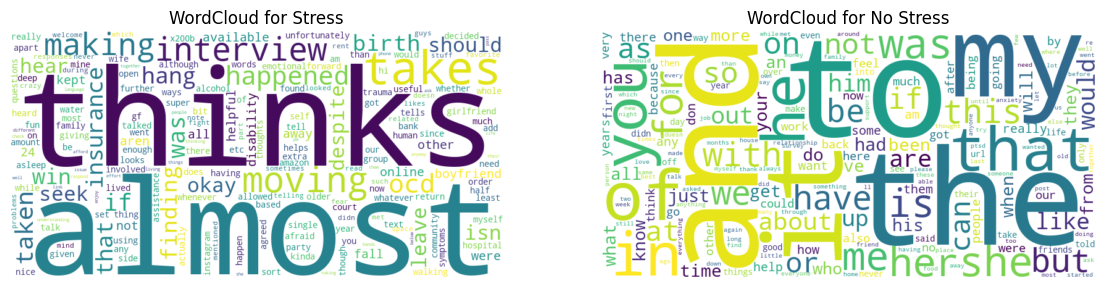

In [16]:
# Separate the texts into "Stress" and "No Stress" categories
stress_text = df[df['label_in_value'] == 'Stress']['text']
no_stress_text = df[df['label_in_value'] == 'No Stress']['text']

# Vectorize the text
vectorizer = TfidfVectorizer(max_features=1000)
stress_vectorized = vectorizer.fit_transform(stress_text)
no_stress_vectorized = vectorizer.fit_transform(no_stress_text)

# Convert to DataFrame for easier handling
stress_words_df = pd.DataFrame(stress_vectorized.toarray(), columns=vectorizer.get_feature_names_out())
no_stress_words_df = pd.DataFrame(no_stress_vectorized.toarray(), columns=vectorizer.get_feature_names_out())

# Sum and sort the TF-IDF values for each word
stress_word_freq = stress_words_df.sum().sort_values(ascending=False)
no_stress_word_freq = no_stress_words_df.sum().sort_values(ascending=False)

# Generate word cloud for Stress and No Stress
stress_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(stress_word_freq)
no_stress_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(no_stress_word_freq)

# Plot the word clouds side by side
plt.figure(figsize=(14, 7))

# WordCloud for Stress
plt.subplot(1, 2, 1)
plt.imshow(stress_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Stress')

# WordCloud for No Stress
plt.subplot(1, 2, 2)
plt.imshow(no_stress_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for No Stress')

plt.show()


## Wordclouds without English stop words

Mostly the same code as the previous approach wexcept now with stop words remopved using the `stop_words='english'` parameter in the vectorizer.

The results of removing stop words seem more interesting, although one could argue why some stopwords might be used more in `stress`/`no stress` texts is value information as well. Thus both were included in this notebook.

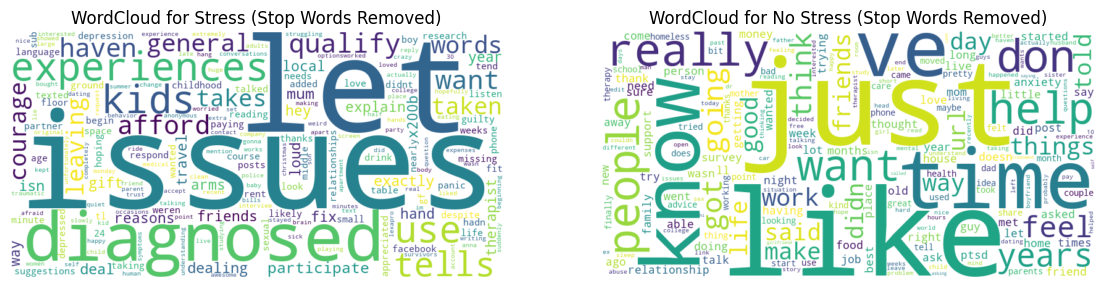

In [17]:
# Use TfidfVectorizer with stop words removed
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# The rest is the same as before
stress_vectorized = vectorizer.fit_transform(stress_text)
no_stress_vectorized = vectorizer.fit_transform(no_stress_text)

stress_words_df = pd.DataFrame(stress_vectorized.toarray(), columns=vectorizer.get_feature_names_out())
no_stress_words_df = pd.DataFrame(no_stress_vectorized.toarray(), columns=vectorizer.get_feature_names_out())

stress_word_freq = stress_words_df.sum().sort_values(ascending=False)
no_stress_word_freq = no_stress_words_df.sum().sort_values(ascending=False)

stress_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(stress_word_freq)
no_stress_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(no_stress_word_freq)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(stress_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Stress (Stop Words Removed)')

plt.subplot(1, 2, 2)
plt.imshow(no_stress_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for No Stress (Stop Words Removed)')

plt.show()

## Final experiment: Naive Bayes without English stop words

Creating the wordclouds without stopwords made me wonder whether the Naive Bayes model might perform better with these words removed as well. As a final experiment this will be done using the same Kfold approach as before.

In [18]:
# Use TfidfVectorizer with stop words removed
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
vectors = vectorizer.fit_transform(df.text)

"""Creating dummy columns for every word in the text column that contain 1 or 0 depending on whether they exist in the text of that row"""
wordsDF_no_stop_words = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())

kf = KFold(n_splits=5, shuffle=True, random_state=42)

test_model_kfold(bayes, wordsDF_no_stop_words, df.type)

    Class  Precision   Recall  F1-Score  Support
No Stress   0.740895 0.606447  0.666204     1350
   Stress   0.693117 0.807912  0.745555     1488

Average Accuracy: 71.14%


## Final thoughts

**Stop words** 

Removing the stop words made the Naive Bayes model less accurate, this does seem to make sense as the wordclouds showed there was a clear distinction between frequently used stop words in `Stress` and `No Stress` cases, which indicates these can do a good job at classifying and don't just act as noise to the model. Still it is probably better to remove them in wordclouds as including the stopwords isn't as interesting and would probably cause the wordclouds of many different datasets to look very similar.

**Naive Bayes**

I am quite pleased with the performance of the Naive Bayes model that uses K-fold cross-validation and includes stop words. 77% precision on `No Stress` and 71% on `Stress` is not too bad considering the model was trained on text from Reddit posts. The model might be able to be improved by also including the subreddit column in the training, I do however feel like this would lead to overfitting and defeats the purpose of the model. Posts from a subreddit like `PTSD` will probably more often than not be stressed, but this would make the model more limitted to just being able to predict `Stress` or `No Stress` of reddit text.

Something I noticed at the very end is that the train_test_split using model varies **a lot** in the results it returns. This is almost certainly caused by the random split sometimes creating a 'golden' training or testing dataset that does a very good job at identifying features of the categories whilst at other times severly underperforming due to an unfortunate training or testing dataset. The K-fold driven model however returns the same scores on every run. Although you can sometimes randomly get a better model with the train_test_split model, I would greatly prefer a consistently fine performing model.

**Further model improvement**

 - Parameter tuning:
 
 I don't believe there is much to gain with parameter optimization of the current models. I have manually played around with the K-fold parameters but these only had a significant impact when made very small or very big. Everything between returned about the same results.
 
 - Confidence column:

 The dataset, other than the label column, also contained a confidence column which could be used to add further depth to the label. I didn't use this column for models in this notebook but I imagine better results could be achieved when this column is properly used.